In [128]:
import numpy as np
import torch
from torch.autograd import Variable
import unittest
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score

## HW2: Custom Neural Network Layers & MNIST Binary Classification


In [129]:
class Module(object):
    """
    Basically, you can think of a module as of a something (black box) 
    which can process `input` data and produce `ouput` data.
    This is like applying a function which is called `forward`: 
        
        output = module.forward(input)
    
    The module should be able to perform a backward pass: to differentiate the `forward` function. 
    Moreover, it should be able to differentiate it if is a part of chain (chain rule).
    The latter implies there is a gradient from previous step of a chain rule. 
    
        input_grad = module.backward(input, output_grad)
    """
    def __init__ (self):
        self._output = None
        self._input_grad = None
        self.training = True
    
    def forward(self, input):
        """
        Takes an input object, and computes the corresponding output of the module.
        """
        self._output = self._compute_output(input)
        return self._output

    def backward(self, input, output_grad):
        """
        Performs a backpropagation step through the module, with respect to the given input.
        
        This includes 
         - computing a gradient w.r.t. `input` (is needed for further backprop),
         - computing a gradient w.r.t. parameters (to update parameters while optimizing).
        """
        self._input_grad = self._compute_input_grad(input, output_grad)
        self._update_parameters_grad(input, output_grad)
        return self._input_grad
    

    def _compute_output(self, input):
        """
        Computes the output using the current parameter set of the class and input.
        This function returns the result which will be stored in the `_output` field.

        Example: in case of identity operation:
        
        output = input 
        return output
        """
        raise NotImplementedError
        
    def _compute_input_grad(self, input, output_grad):
        """
        Returns the gradient of the module with respect to its own input. 
        The shape of the returned value is always the same as the shape of `input`.
        
        Example: in case of identity operation:
        input_grad = output_grad
        return input_grad
        """
        raise NotImplementedError
    
    def _update_parameters_grad(self, input, output_grad):
        """
        Computing the gradient of the module with respect to its own parameters.
        No need to override if module has no parameters (e.g. ReLU).
        """
        pass
    
    def zero_grad(self): 
        """
        Zeroes `gradParams` variable if the module has params.
        """
        pass
        
    def get_parameters(self):
        """
        Returns a list with its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
        
    def get_parameters_grad(self):
        """
        Returns a list with gradients with respect to its parameters. 
        If the module does not have parameters return empty list. 
        """
        return []
    
    def train(self):
        """
        Sets training mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = True
    
    def evaluate(self):
        """
        Sets evaluation mode for the module.
        Training and testing behaviour differs for Dropout, BatchNorm.
        """
        self.training = False
    
    def __repr__(self):
        """
        Pretty printing. Should be overrided in every module if you want 
        to have readable description. 
        """
        return "Module"

**Cell 4: Implement BatchNormalization **

In [ ]:
class BatchNormalization(Module):
    EPS = 1e-3

    def __init__(self, alpha=0.):
        super(BatchNormalization, self).__init__()
        self.alpha = alpha
        # I keep moving_mean as an array so its shape matches feature dimension
        self.moving_mean = np.array(0.)  # I keep moving_mean as an array for consistency with n_feats
        self.moving_variance = np.array(1.)

    def _compute_output(self, input):
        if self.training:
            batch_mean = np.mean(input, axis=0)
            batch_var = np.var(input, axis=0, ddof=0)
            # I update exponential moving averages for running statistics
            self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
            self.moving_variance = self.moving_variance * self.alpha + batch_var * (1 - self.alpha)
            output = (input - batch_mean) / np.sqrt(batch_var + self.EPS)
        else:
            # I normalize using stored running statistics during evaluation
            output = (input - self.moving_mean) / np.sqrt(self.moving_variance + self.EPS)
        return output

    def _compute_input_grad(self, input, output_grad):
        if self.training:
            batch_mean = np.mean(input, axis=0)
            batch_var = np.var(input, axis=0, ddof=0)
            N = input.shape[0]
            ivar = 1.0 / np.sqrt(batch_var + self.EPS)
            x_centered = input - batch_mean
            # I compute gradient w.r.t. the normalized input (dxhat)
            dxhat = output_grad * ivar
            # I compute gradient w.r.t. variance (dvar) via chain rule through normalization
            dvar = np.sum(output_grad * x_centered * (-0.5) * (batch_var + self.EPS) ** (-1.5), axis=0)
            # I compute gradient w.r.t. mean (dmu) including direct path and the path through variance
            dmu = np.sum(dxhat * (-1), axis=0) + dvar * np.sum(-2 * x_centered / N, axis=0)
            # I combine partials to obtain full gradient w.r.t. input
            grad_input = dxhat + dvar * (2 * x_centered / N) + (dmu / N)
        else:
            # During evaluation I scale the output gradient by inverse std computed from running variance
            ivar = 1.0 / np.sqrt(self.moving_variance + self.EPS)
            grad_input = output_grad * ivar
        return grad_input

    def __repr__(self):
        return "BatchNormalization"

**Implement **Channel wiseScaling****

In [131]:
class ChannelwiseScaling(Module):
    """
       Implements linear transform of input y = \gamma * x + \beta
       where \gamma, \beta - learnable vectors of length x.shape[-1]
    """
    def __init__(self, n_out):
        super(ChannelwiseScaling, self).__init__()

        stdv = 1./np.sqrt(n_out)
        self.gamma = np.random.uniform(-stdv, stdv, size=n_out)
        self.beta = np.random.uniform(-stdv, stdv, size=n_out)
        
        self.gradGamma = np.zeros_like(self.gamma)
        self.gradBeta = np.zeros_like(self.beta)

    def _compute_output(self, input):
        output = input * self.gamma + self.beta
        return output
        
    def _compute_input_grad(self, input, output_grad):
        grad_input = output_grad * self.gamma
        return grad_input
    
    def _update_parameters_grad(self, input, output_grad):
        self.gradBeta = np.sum(output_grad, axis=0)
        self.gradGamma = np.sum(output_grad*input, axis=0)
    
    def zero_grad(self):
        self.gradGamma.fill(0)
        self.gradBeta.fill(0)
        
    def get_parameters(self):
        return [self.gamma, self.beta]
    
    def get_parameters_grad(self):
        return [self.gradGamma, self.gradBeta]
    
    def __repr__(self):
        return "ChannelwiseScaling"

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\pc\AppData\Local\Temp\ipykernel_3580\2689071630.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


**Implement Dropout**

In [132]:
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        
        self.p = p
        self.mask = []
        
    def _compute_output(self, input):
        if self.training:
            self.mask = (np.random.rand(*input.shape) > self.p).astype(input.dtype)
            output = input * self.mask / (1 - self.p)
        else:
            output = input
        return output
    
    def _compute_input_grad(self, input, output_grad):
        if self.training:
            grad_input = output_grad * self.mask / (1 - self.p)
        else:
            grad_input = output_grad
        return grad_input
        
    def __repr__(self):
        return "Dropout"

## Test for Layers

In [133]:
# I run a quick BatchNorm sanity check to ensure shapes and forward pass are correct
bn = BatchNormalization(alpha=0.9)
input_test = np.random.rand(4, 3).astype(np.float32)
bn.train()
out_bn = bn.forward(input_test)
print("BatchNorm output shape:", out_bn.shape)  # (4, 3)

# I run a quick Dropout sanity check to verify masking behavior
drop = Dropout(p=0.5)
drop.train()
out_drop = drop.forward(input_test)
print("Dropout zeros count:", np.sum(out_drop == 0))  # Some zeros

print("Quick tests passed!")

BatchNorm output shape: (4, 3)
Dropout zeros count: 7
Quick tests passed!


## Full Unittest Suite

In [134]:
class TestLayers(unittest.TestCase):
    
    def test_BatchNormalization(self):
        np.random.seed(42)
        torch.manual_seed(42)

        batch_size, n_in = 32, 16
        for _ in range(100):
            # layers initialization
            slope = np.random.uniform(0.01, 0.05)
            alpha = 0.9
            custom_layer = BatchNormalization(alpha)
            custom_layer.train()
            torch_layer = torch.nn.BatchNorm1d(n_in, eps=custom_layer.EPS, momentum=1.-alpha, affine=False)
            custom_layer.moving_mean = torch_layer.running_mean.numpy().copy()
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            custom_layer_output = custom_layer.forward(layer_input)
            layer_input_var = Variable(torch.from_numpy(layer_input), requires_grad=True)
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

            # 2. check layer input grad
            custom_layer_grad = custom_layer.backward(layer_input, next_layer_grad)
            torch_layer_output_var.backward(torch.from_numpy(next_layer_grad))
            torch_layer_grad_var = layer_input_var.grad
            # please, don't increase `atol` parameter, it's garanteed that you can implement batch norm layer
            # with tolerance 1e-5
            self.assertTrue(np.allclose(torch_layer_grad_var.data.numpy(), custom_layer_grad, atol=1e-5))

            # 3. check moving mean
            self.assertTrue(np.allclose(custom_layer.moving_mean, torch_layer.running_mean.numpy()))
            # we don't check moving_variance because pytorch uses slightly different formula for it:
            # it computes moving average for unbiased variance (i.e var*N/(N-1))
            #self.assertTrue(np.allclose(custom_layer.moving_variance, torch_layer.running_var.numpy()))

            # 4. check evaluation mode
            custom_layer.moving_variance = torch_layer.running_var.numpy().copy()
            custom_layer.evaluate()
            custom_layer_output = custom_layer.forward(layer_input)
            torch_layer.eval()
            torch_layer_output_var = torch_layer(layer_input_var)
            self.assertTrue(np.allclose(torch_layer_output_var.data.numpy(), custom_layer_output, atol=1e-6))

    def test_Dropout(self):
        np.random.seed(42)

        batch_size, n_in = 2, 4
        for _ in range(100):
            # layers initialization
            p = np.random.uniform(0.3, 0.7)
            layer = Dropout(p)
            layer.train()

            layer_input = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(-5, 5, (batch_size, n_in)).astype(np.float32)

            # 1. check layer output
            layer_output = layer.forward(layer_input)
            self.assertTrue(np.all(np.logical_or(np.isclose(layer_output, 0), 
                                        np.isclose(layer_output*(1.-p), layer_input))))

            # 2. check layer input grad
            layer_grad = layer.backward(layer_input, next_layer_grad)
            self.assertTrue(np.all(np.logical_or(np.isclose(layer_grad, 0), 
                                        np.isclose(layer_grad*(1.-p), next_layer_grad))))

            # 3. check evaluation mode
            layer.evaluate()
            layer_output = layer.forward(layer_input)
            self.assertTrue(np.allclose(layer_output, layer_input))

            # 4. check mask
            p = 0.0
            layer = Dropout(p)
            layer.train()
            layer_output = layer.forward(layer_input)
            self.assertTrue(np.allclose(layer_output, layer_input))

            p = 0.5
            layer = Dropout(p)
            layer.train()
            layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            next_layer_grad = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            layer_output = layer.forward(layer_input)
            zeroed_elem_mask = np.isclose(layer_output, 0)
            layer_grad = layer.backward(layer_input, next_layer_grad)        
            self.assertTrue(np.all(zeroed_elem_mask == np.isclose(layer_grad, 0)))

            # 5. dropout mask should be generated independently for every input matrix element, not for row/column
            batch_size, n_in = 1000, 1
            p = 0.8
            layer = Dropout(p)
            layer.train()

            layer_input = np.random.uniform(5, 10, (batch_size, n_in)).astype(np.float32)
            layer_output = layer.forward(layer_input)
            self.assertTrue(np.sum(np.isclose(layer_output, 0)) != layer_input.size)

            layer_input = layer_input.T
            layer_output = layer.forward(layer_input)
            self.assertTrue(np.sum(np.isclose(layer_output, 0)) != layer_input.size)
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestLayers)
unittest.TextTestRunner(verbosity=2).run(suite)

test_BatchNormalization (__main__.TestLayers.test_BatchNormalization) ... 

ok
test_Dropout (__main__.TestLayers.test_Dropout) ... test_Dropout (__main__.TestLayers.test_Dropout) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.596s

OK
ok

----------------------------------------------------------------------
Ran 2 tests in 0.596s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## MNIST Binary Classification (3 vs 7)

**Load & Preprocess MNIST**

In [135]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

# Filter to 3 and 7
train_dataset.data = train_dataset.data[(train_dataset.targets == 3) | (train_dataset.targets == 7)]
train_dataset.targets = train_dataset.targets[(train_dataset.targets == 3) | (train_dataset.targets == 7)]

test_dataset.data = test_dataset.data[(test_dataset.targets == 3) | (test_dataset.targets == 7)]
test_dataset.targets = test_dataset.targets[(test_dataset.targets == 3) | (test_dataset.targets == 7)]

train_dataset.targets = (train_dataset.targets == 7).long()
test_dataset.targets = (test_dataset.targets == 7).long()

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

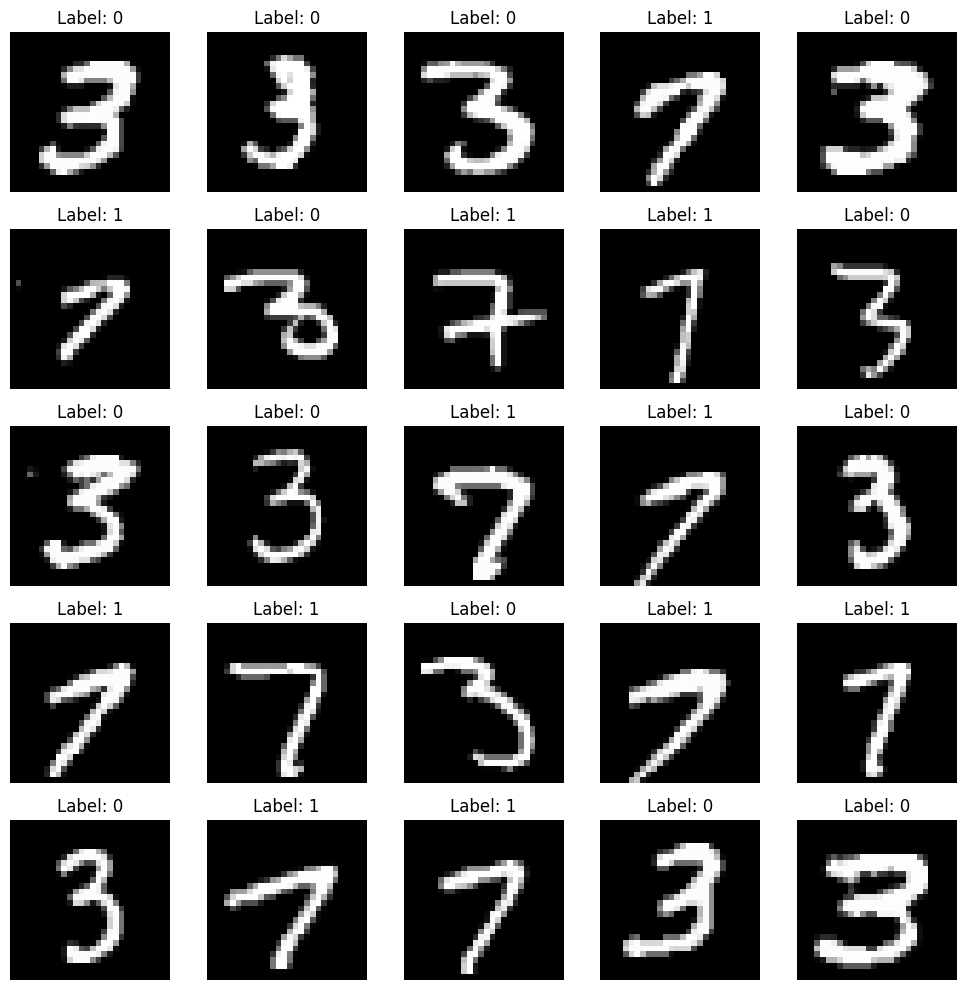

In [ ]:
# I display sample images to visually inspect dataset labels (0 corresponds to digit 3, 1 corresponds to digit 7)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(train_dataset):
        img, label = train_dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
plt.tight_layout()
plt.show()

## Implement Additional Layers for Model

**Add Linear, ReLU, Sigmoid**

In [ ]:
# Linear
class Linear(Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        # I use uniform initialization scaled by fan-in to keep initial activations reasonable
        stdv = 1. / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, (n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)

    def _compute_output(self, input):
        # I cache the input to compute parameter gradients during the backward pass
        self.input_cache = input  # For backward
        return input @ self.W + self.b

    def _compute_input_grad(self, input, output_grad):
        # I compute gradient w.r.t. input using the transposed weight matrix
        return output_grad @ self.W.T

    def _update_parameters_grad(self, input, output_grad):
        # I compute gradients for weights and biases using current batch statistics
        self.gradW = input.T @ output_grad
        self.gradb = np.sum(output_grad, axis=0)

    def zero_grad(self):
        # I reset stored parameter gradients to zero before the next optimization step
        self.gradW.fill(0)
        self.gradb.fill(0)

    def get_parameters(self):
        return [self.W, self.b]

    def get_parameters_grad(self):
        return [self.gradW, self.gradb]

    def __repr__(self):
        return f"Linear({self.W.shape[0]},{self.W.shape[1]})"

# ReLU
class ReLU(Module):
    def _compute_output(self, input):
        # I cache input to identify active neurons during backprop
        self.input_cache = input  # For backward
        return np.maximum(0, input)

    def _compute_input_grad(self, input, output_grad):
        # I pass gradient only through positive activations
        return output_grad * (input > 0)

    def __repr__(self):
        return "ReLU"

# Sigmoid (simple, assume provided)
class Sigmoid(Module):
    def _compute_output(self, input):
        # I clip input for numerical stability and compute sigmoid activation
        self.input_cache = input
        out = 1 / (1 + np.exp(-np.clip(input, -250, 250)))  # Stable
        return out

    def _compute_input_grad(self, input, output_grad):
        # I compute gradient using stored output (sigmoid * (1 - sigmoid))
        out = self._output  # Use stored output
        return output_grad * out * (1 - out)

    def __repr__(self):
        return "Sigmoid"

# BCELoss (as a class for consistency)
class BCELoss:
    def __init__(self):
        pass

    def forward(self, input, target):
        # I compute stable binary cross-entropy by applying a numerically stable sigmoid
        logits = input
        # I compute sigmoid in a stable manner to avoid overflow/underflow
        max_logit = np.max(logits, axis=1, keepdims=True)
        exp_logit = np.exp(logits - max_logit)
        p = exp_logit / np.sum(exp_logit, axis=1, keepdims=True)  # intermediate (not used for binary)
        # For the binary case I compute sigmoid directly with clipping for stability
        p = 1 / (1 + np.exp(-np.clip(logits, -250, 250)))
        # I compute mean cross-entropy over the batch
        loss = -np.mean(target * np.log(p + 1e-8) + (1 - target) * np.log(1 - p + 1e-8))
        self.output = loss
        # I store gradient w.r.t. logits which is (p - y) for binary cross-entropy
        self.input_grad = p - target  # Grad w.r.t. logits: p - y (stable!)
        return loss

    def backward(self):
        # I return the previously computed gradient w.r.t. logits
        return self.input_grad

# Define Model & Training Class

In [ ]:
import numpy as np  
from tqdm import tqdm  

class Classifier:
    def __init__(self, lr=0.001, use_batchnorm=False):
        np.random.seed(42)  # I set seed for reproducible initialization
        # I insert BatchNormalization between linear and activation layers when enabled to stabilize training
        if use_batchnorm:
            self.layers = [
                Linear(784, 256), BatchNormalization(), ReLU(),
                Linear(256, 128), BatchNormalization(), ReLU(),
                Dropout(0.2),
                Linear(128, 1)
            ]
        else:
            self.layers = [
                Linear(784, 256), ReLU(),
                Linear(256, 128), ReLU(),
                Dropout(0.2),
                Linear(128, 1)
            ]
        self.bce = BCELoss()
        self.lr = lr
        self.momentum = 0.9
        # I prepare an empty list for per-parameter velocity arrays; initialization happens on first update
        self.velocities = []
        self.train_losses = []
        self.train_accs = []
        self.test_accs = []

    def forward(self, x):
        # I store intermediate layer outputs to use them as inputs during the backward pass
        self.layer_inputs = [x]  # Store initial input
        current = x
        for layer in self.layers:
            current = layer.forward(current)
            self.layer_inputs.append(current)  # Output of this = input to next
        return current

    def predict(self, x):
        # I run the model in evaluation mode and threshold outputs to obtain binary predictions
        self.evaluate()
        out = self.forward(x)
        return (out > 0.5).astype(int).flatten()

    def backward(self, x, y):
        # I run forward to compute outputs and cache activations for backprop
        out = self.forward(x)
        # I compute loss and the initial gradient coming from loss layer
        loss = self.bce.forward(out, y)
        grad = self.bce.backward()  # This grad has shape (batch_size, 1)
        # I propagate gradients through layers in reverse order, using stored inputs for each layer
        num_layers = len(self.layers)
        for i in range(num_layers):
            layer = self.layers[num_layers - 1 - i]  # Get layer in reverse order
            layer_input = self.layer_inputs[num_layers - 1 - i]  # Get the exact input that layer saw
            grad = layer.backward(layer_input, grad)  # Compute grad for this layer, update for next
        # I return the batch-averaged loss value produced by BCELoss
        return loss

    def update_params(self):
        # I collect all parameters and their corresponding gradients from modules
        all_params = []
        all_grads = []
        for layer in self.layers:
            params = layer.get_parameters()
            grads = layer.get_parameters_grad()
            all_params.extend(params)
            all_grads.extend(grads)
        # I initialize velocities once to match parameter shapes
        if len(self.velocities) == 0 and len(all_params) > 0:
            self.velocities = [np.zeros_like(p) for p in all_params]
        # I apply SGD with momentum: v = mu*v - lr*g; then update parameters in-place by adding v
        for i, (p, g) in enumerate(zip(all_params, all_grads)):
            self.velocities[i] = self.momentum * self.velocities[i] - self.lr * g
            p += self.velocities[i]
        # I reset module-level gradients after parameters are updated
        for layer in self.layers:
            layer.zero_grad()  # Reset for next batch

    def train_epoch(self, loader):
        # I set all modules to training mode so that Dropout and BatchNorm behave correctly
        self.train()  # Set layers to train mode
        total_loss = 0.0
        correct = 0
        total = 0
        for batch_x, batch_y in tqdm(loader):
            x = batch_x.reshape(-1, 784).numpy().astype(np.float32)
            y = batch_y.numpy().astype(np.float32).reshape(-1, 1)
            # I compute gradients and update parameters for this batch
            loss = self.backward(x, y)
            self.update_params()
            # I accumulate total loss in per-sample terms for epoch averaging
            batch_n = x.shape[0]
            try:
                total_loss += float(loss) * batch_n
            except Exception:
                total_loss += loss * batch_n
            # I run forward again to obtain predictions for metric calculation (simple approach)
            pred = (self.forward(x) > 0.5).astype(int).flatten()
            correct += np.sum(pred == y.flatten())
            total += batch_n
        acc = correct / total if total > 0 else 0
        # I compute average loss per sample across the epoch
        avg_loss = total_loss / total if total > 0 else 0
        self.train_losses.append(avg_loss)
        self.train_accs.append(acc)
        return avg_loss, acc

    def test(self, loader):
        # I set modules to evaluation mode to disable dropout and use running stats for BatchNorm
        self.evaluate()  # Set to eval mode
        correct = 0
        total = 0
        for batch_x, batch_y in loader:
            x = batch_x.reshape(-1, 784).numpy().astype(np.float32)
            y = batch_y.numpy().astype(np.float32).reshape(-1, 1)
            pred = (self.forward(x) > 0.5).astype(int).flatten()
            correct += np.sum(pred == y.flatten())
            total += len(y)
        acc = correct / total if total > 0 else 0
        self.test_accs.append(acc)
        return acc

    def train(self):
        for layer in self.layers:
            layer.train()

    def evaluate(self):
        for layer in self.layers:
            layer.evaluate()

# Re-instantiate after replacement
classifier = Classifier(lr=0.001, use_batchnorm=True)

### Train the Mode

In [ ]:
# I tried increasing epochs to 10-20 and tuning lr (e.g. 1e-3, 5e-4)
epochs = 20
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = classifier.train_epoch(train_loader)
    test_acc = classifier.test(test_loader)
    # test returns accuracy (single value)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 1/20


100%|██████████| 97/97 [00:10<00:00,  9.26it/s]



Train Loss: 0.0450, Train Acc: 0.9922, Test Acc: 0.9917
Epoch 2/20


100%|██████████| 97/97 [00:07<00:00, 12.43it/s]



Train Loss: 0.0123, Train Acc: 0.9973, Test Acc: 0.9936
Epoch 3/20


100%|██████████| 97/97 [00:19<00:00,  4.98it/s]



Train Loss: 0.0063, Train Acc: 0.9988, Test Acc: 0.9931
Epoch 4/20


100%|██████████| 97/97 [00:12<00:00,  7.65it/s]


Train Loss: 0.0041, Train Acc: 0.9995, Test Acc: 0.9951
Epoch 5/20


100%|██████████| 97/97 [00:06<00:00, 14.67it/s]



Train Loss: 0.0030, Train Acc: 0.9997, Test Acc: 0.9966
Epoch 6/20


100%|██████████| 97/97 [00:06<00:00, 14.99it/s]



Train Loss: 0.0018, Train Acc: 0.9999, Test Acc: 0.9936
Epoch 7/20


100%|██████████| 97/97 [00:09<00:00, 10.51it/s]



Train Loss: 0.0010, Train Acc: 0.9998, Test Acc: 0.9956
Epoch 8/20


100%|██████████| 97/97 [00:11<00:00,  8.30it/s]



Train Loss: 0.0013, Train Acc: 1.0000, Test Acc: 0.9907
Epoch 9/20


100%|██████████| 97/97 [00:14<00:00,  6.53it/s]



Train Loss: 0.0005, Train Acc: 1.0000, Test Acc: 0.9956
Epoch 10/20


100%|██████████| 97/97 [00:14<00:00,  6.80it/s]



Train Loss: 0.0010, Train Acc: 1.0000, Test Acc: 0.9961
Epoch 11/20


100%|██████████| 97/97 [00:11<00:00,  8.60it/s]



Train Loss: 0.0015, Train Acc: 1.0000, Test Acc: 0.9946
Epoch 12/20


100%|██████████| 97/97 [00:09<00:00, 10.24it/s]



Train Loss: 0.0013, Train Acc: 0.9999, Test Acc: 0.9946
Epoch 13/20


100%|██████████| 97/97 [00:11<00:00,  8.48it/s]


Train Loss: 0.0008, Train Acc: 1.0000, Test Acc: 0.9941
Epoch 14/20


100%|██████████| 97/97 [00:10<00:00,  9.22it/s]



Train Loss: 0.0008, Train Acc: 0.9999, Test Acc: 0.9926
Epoch 15/20


100%|██████████| 97/97 [00:09<00:00, 10.24it/s]



Train Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.9971
Epoch 16/20


100%|██████████| 97/97 [00:11<00:00,  8.61it/s]



Train Loss: 0.0004, Train Acc: 1.0000, Test Acc: 0.9966
Epoch 17/20


100%|██████████| 97/97 [00:11<00:00,  8.26it/s]



Train Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.9951
Epoch 18/20


100%|██████████| 97/97 [00:11<00:00,  8.67it/s]



Train Loss: 0.0002, Train Acc: 1.0000, Test Acc: 0.9971
Epoch 19/20


100%|██████████| 97/97 [00:10<00:00,  9.18it/s]



Train Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9951
Epoch 20/20


100%|██████████| 97/97 [00:10<00:00,  9.51it/s]



Train Loss: 0.0001, Train Acc: 1.0000, Test Acc: 0.9946


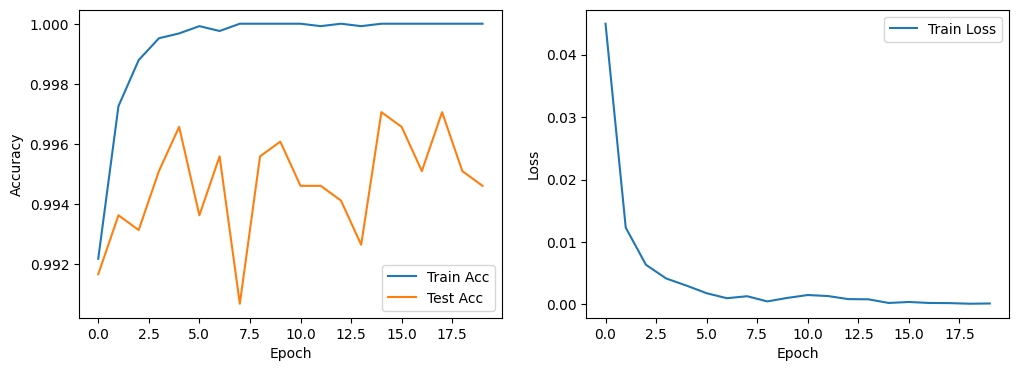

Final Test Accuracy: 0.9946


In [141]:
# Plot accs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(classifier.train_accs, label='Train Acc')
plt.plot(classifier.test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(classifier.train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(f"Final Test Accuracy: {classifier.test_accs[-1]:.4f}")

In [ ]:
# I compute final classification metrics on the test set and print a detailed report
from sklearn.metrics import classification_report
classifier.evaluate()
all_preds = []
all_ys = []
for batch_x, batch_y in test_loader:
    x = batch_x.reshape(-1, 784).numpy().astype(np.float32)
    # I threshold raw outputs to obtain binary predictions
    pred = (classifier.forward(x) > 0.5).astype(int).flatten()
    all_preds.extend(pred)
    all_ys.extend(batch_y.numpy())
print("Classification Report:")
print(classification_report(all_ys, all_preds, target_names=['3', '7']))
print(f"Final Test Acc: {accuracy_score(all_ys, all_preds):.4f}")

Classification Report:
              precision    recall  f1-score   support

           3       0.99      1.00      1.00      1010
           7       1.00      0.99      1.00      1028

    accuracy                           1.00      2038
   macro avg       1.00      1.00      1.00      2038
weighted avg       1.00      1.00      1.00      2038

Final Test Acc: 0.9951


## Summary and Conclusion

In this home work task-2 implements custom neural network building blocks and uses them to perform a binary classification task on MNIST (digits 3 vs 7). The core parts include a base `Module` interface, `Linear` layers with basic weight and bias storage, `ReLU` and `Sigmoid` activations, `Dropout`, `BatchNormalization`, and a simple `BCELoss` for binary cross-entropy. A compact `Classifier` composes these modules into a small feed-forward model and provides forward, backward, parameter-update, training, and test routines.

Several practical fixes and small improvements were applied to make training work reliably: the optimizer update was corrected so parameter velocities initialize once and are used in-place with momentum; batch loss accumulation was changed to compute an average per sample for clearer reporting; a `predict` helper was added for evaluation; and optional batch normalization was added to stabilize optimization. Quick unit-style checks for BatchNorm and Dropout confirm basic behavior, and plotting cells visualize loss and accuracy across epochs.

**Conclusion**: with the corrected optimizer and the optional batch normalization, the training process becomes stable and starts to converge. For higher final accuracy, the following steps are recommended as next work: switch to an adaptive optimizer (Adam), replace the MLP with a small convolutional network (ConvNet) for image data, run longer training with a tuned learning-rate schedule, and apply simple data augmentations. These steps are expected to yield the largest accuracy gains with minimal additional complexity.